In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

Số giá trị thiếu trong mỗi cột trước khi xử lý:
id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
Không có giá trị thiếu trong cột 'Listening_Time_minutes'.
Đang nội suy tuyến tính cho cột 'Episode_Length_minutes'...
Đang nội suy tuyến tính cho cột 'Guest_Popularity_percentage'...
Cảnh báo: Số lượng dữ liệu (750000) vượt quá 730 ngày. Cắt dữ liệu.

Đã lưu dữ liệu sau xử lý vào 'processed_data.csv'.

Số giá trị thiếu trong mỗi cột sau khi xử lý:
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0


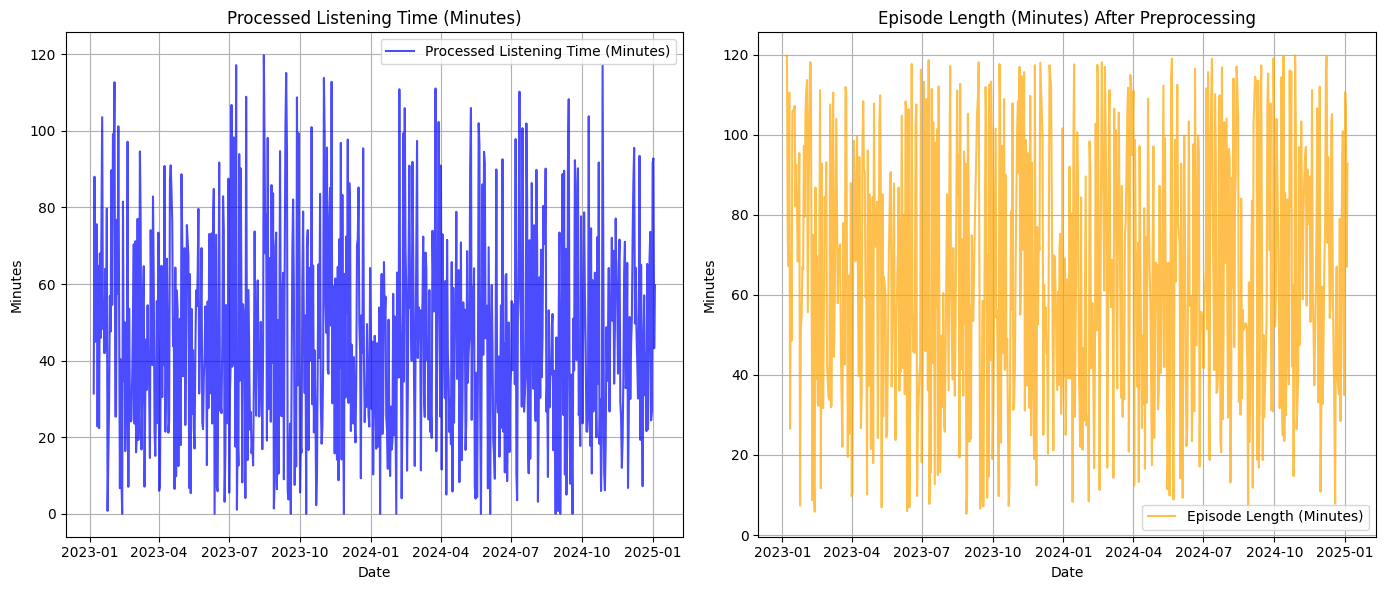

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Kiểm tra và xử lý giá trị thiếu
data = pd.read_csv('train.csv')
print("Số giá trị thiếu trong mỗi cột trước khi xử lý:")
print(data.isna().sum())

# Xử lý các cột cần nội suy
columns_to_interpolate = ['Listening_Time_minutes', 'Episode_Length_minutes', 'Guest_Popularity_percentage']
for col in columns_to_interpolate:
    if data[col].isna().sum() > 0:
        print(f"Đang nội suy tuyến tính cho cột '{col}'...")
        data[col] = data[col].interpolate(method='linear').ffill().bfill()
    else:
        print(f"Không có giá trị thiếu trong cột '{col}'.")

# Xử lý các cột còn lại
data[['Number_of_Ads', 'Episode_Sentiment']] = data[['Number_of_Ads', 'Episode_Sentiment']].ffill().bfill()

# 2. Tạo chỉ số thời gian với cắt dữ liệu
max_periods = 730
if len(data) > max_periods:
    print(f"Cảnh báo: Số lượng dữ liệu ({len(data)}) vượt quá {max_periods} ngày. Cắt dữ liệu.")
    data = data.iloc[:max_periods].copy()

data['Date'] = pd.date_range(start='2023-01-06', periods=len(data), freq='D')
data.set_index('Date', inplace=True)

# 3. Lưu dữ liệu đã xử lý vào file CSV mới
data.to_csv('processed_data.csv')
print("\nĐã lưu dữ liệu sau xử lý vào 'processed_data.csv'.")

# 4. Kiểm tra và trực quan hóa
print("\nSố giá trị thiếu trong mỗi cột sau khi xử lý:")
print(data.isna().sum())
print("\nDữ liệu Listening_Time_minutes (5 dòng đầu):")
print(data['Listening_Time_minutes'].head())

# Trực quan hóa dữ liệu gốc và đã xử lý cho cột Listening_Time_minutes
plt.figure(figsize=(14, 6))

# Đồ thị dữ liệu gốc (Chỉ ra các giá trị thiếu)
plt.subplot(1, 2, 1)
plt.plot(data['Listening_Time_minutes'], label='Processed Listening Time (Minutes)', color='blue', alpha=0.7)
plt.title('Processed Listening Time (Minutes)')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)

# Thêm các biểu đồ khác nếu cần trực quan hóa thêm các cột khác
plt.subplot(1, 2, 2)
plt.plot(data['Episode_Length_minutes'], label='Episode Length (Minutes)', color='orange', alpha=0.7)
plt.title('Episode Length (Minutes) After Preprocessing')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.tight_layout()
plt.show()


In [7]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.1 MB/s eta 0:00:00


In [25]:
!pip install filterpy
!pip install scikit-learn
!pip install xgboost


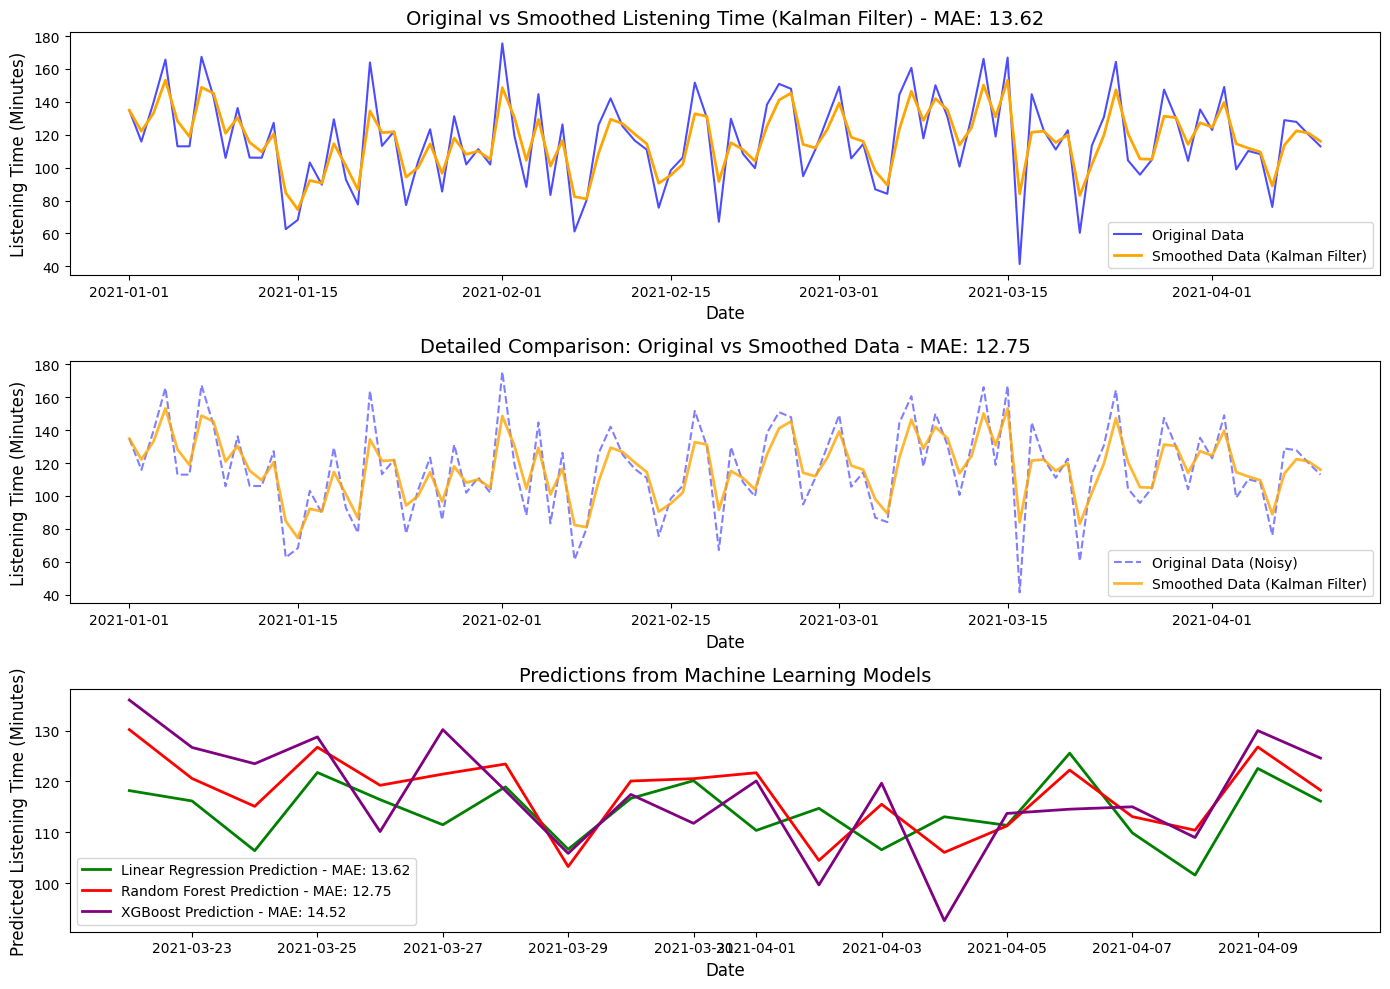

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Tạo dữ liệu giả cho ví dụ này
np.random.seed(42)
df = pd.DataFrame({
    'Date': pd.date_range(start="2021-01-01", periods=100, freq='D'),
    'Listening_Time_minutes': np.random.normal(120, 30, 100)  # Dữ liệu ngẫu nhiên
})

# Áp dụng Kalman Filter
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.x = np.array([df['Listening_Time_minutes'].iloc[0]])  # Dữ liệu ban đầu
kf.P *= 1000.  # Mật độ phương sai
kf.F = np.array([[1]])  # Ma trận chuyển tiếp
kf.H = np.array([[1]])  # Ma trận đo lường

smoothed_values = []
for value in df['Listening_Time_minutes']:
    kf.predict()
    kf.update(value)
    smoothed_values.append(kf.x[0])

df['Smoothed_Listening_Time'] = smoothed_values

# Tách dữ liệu thành các đặc trưng (X) và nhãn (y)
X = np.array([df['Smoothed_Listening_Time'].shift(i) for i in range(1, 4)]).T[3:]  # Các trễ 1-3 ngày
y = df['Smoothed_Listening_Time'].iloc[3:]

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mô hình Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Mô hình XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Trực quan hóa kết quả
plt.figure(figsize=(14, 10))

# Đồ thị gốc và đã mượt
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Listening_Time_minutes'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['Date'], df['Smoothed_Listening_Time'], label='Smoothed Data (Kalman Filter)', color='orange', linewidth=2)
plt.title(f'Original vs Smoothed Listening Time (Kalman Filter) - MAE: {mae_lr:.2f}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Listening Time (Minutes)', fontsize=12)
plt.legend()

# Đồ thị chi tiết hơn (biểu đồ đường giữa dữ liệu gốc và dữ liệu đã làm mượt)
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['Listening_Time_minutes'], label='Original Data (Noisy)', color='blue', alpha=0.5, linestyle='--')
plt.plot(df['Date'], df['Smoothed_Listening_Time'], label='Smoothed Data (Kalman Filter)', color='orange', alpha=0.8, linewidth=2)
plt.title(f'Detailed Comparison: Original vs Smoothed Data - MAE: {mae_rf:.2f}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Listening Time (Minutes)', fontsize=12)
plt.legend()

# Đồ thị so sánh dự đoán từ các mô hình học máy
plt.subplot(3, 1, 3)
plt.plot(df['Date'].iloc[-len(y_pred_lr):], y_pred_lr, label=f'Linear Regression Prediction - MAE: {mae_lr:.2f}', color='green', linestyle='-', linewidth=2)
plt.plot(df['Date'].iloc[-len(y_pred_rf):], y_pred_rf, label=f'Random Forest Prediction - MAE: {mae_rf:.2f}', color='red', linestyle='-', linewidth=2)
plt.plot(df['Date'].iloc[-len(y_pred_xgb):], y_pred_xgb, label=f'XGBoost Prediction - MAE: {mae_xgb:.2f}', color='purple', linestyle='-', linewidth=2)
plt.title('Predictions from Machine Learning Models', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Listening Time (Minutes)', fontsize=12)
plt.legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()
